# Gaussian_Process_in_practice
这个例子主要是利用高斯过程的先验分布，将样本绘制成曲线。然后更新参数，利用后验分布获得新的曲线。


## 1. 先验分布
#### 1.1 多变量高斯分布
- 创建一个包含n个候选输入位置的列表{xi，i=1，…，n}
- 初始化均值向量μ和协方差矩阵K（含n x n个元素）
    - 假设x_1和x_2是多维的矩阵。x_1是一个 m* d的矩阵，x_2是一个n*d的矩阵，那么K是一个m*n的矩阵，K[i,j] = k(x_1[i,:], x_2[j,:])
    
- 执行Cholesky分解K=LL T来获得L
- 通过LN（0,I）获得N（0,K）上的一个样本并存储在f_prior中


multivariante_samples01 和multivariante_samples02 这两个function的作用是一样的，只不过有两种写法。


#### 1.2 看图可知
- 从先验过程采样的五个例子，其中大多数函数的值落在95%的可信区间内。

X_test的shape是(100, 1)
K_multi的shape是(100, 100)


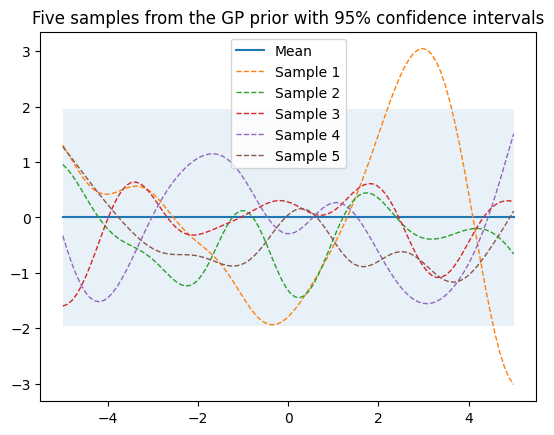

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# 设置随机种子以确保重复性
np.random.seed(8)

def plot_gp(mu, cov, title_str, X, X_train=None, Y_train=None, samples=[] ):
    X = X.ravel() # X.ravel()用于将多维数组X展平为一维数组。
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov)) # 通过计算协方差矩阵的对角线元素的平方根，可以得到每个参数的标准差。乘以 1.96，可以得到一个置信区间，表示该参数的不确定性范围。
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sampel in enumerate(samples):
        plt.plot(X, sampel, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()
    plt.title(title_str)



def kernel(a, b):
    """定义一个核函数，返回两个输入位置之间的平方指数距离
    将平方运算分解为三个部分
    每个输入位置是多维的，因此需要对所有维度求和
    """
    sq_dist = np.sum(a**2,1).reshape(-1,1) +np.sum(b**2,1) - 2*np.dot(a,b.T)
    return np.exp(-sq_dist)

def ise_kernel(X1, X2, l=1.0, sigma_f = 1.0):
    """
    Isotropic squared exponential kernel.
    kernel是ise_kernel的特殊情况，l=1.0, sigma_f = 1.0
    """
    sq_dist = np.sum(X1**2, 1).reshape(-1,1) + np.sum(X2**2,1) - 2*np.dot(X1,X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sq_dist)


def multivariante_samples01(X, l=1.0, sigma_f=1.0):
    """
    生成多元高斯过程的样本:通过标准正态分布生成的随机数，乘以L，得到一个多元高斯分布的随机数
    """
    # 计算pairwise distance, 得到一个nxn 矩阵
    mu = np.zeros(X.shape)
    K = ise_kernel(X, X, l, sigma_f)
    L = np.linalg.cholesky(K + 1e-6*np.eye(len(X)))
    samples = np.dot(L, np.random.normal(size=(len(X), 5)))
    return samples, K, mu

def multivariante_samples02(X, l=1.0, sigma_f=1.0):
    """
    生成多元高斯过程的样本：调用np.random.multivariate_normal()函数，得到一个多元高斯分布的随机数
    """
    # 计算pairwise distance, 得到一个nxn 矩阵

    mu = np.zeros(X.shape)
    K = ise_kernel(X, X)
    samples = np.random.multivariate_normal(mu.ravel(), K, 5)
    return samples, K, mu

# 设置当函数增长到无穷大时函数的输入位置数量 setting number of input locations which approximates a function when growing to infinity
n = 100
X_test = np.linspace(-5,5,n).reshape(-1,1) 
print(f"X_test的shape是{X_test.shape}")


samples, K, mu = multivariante_samples02(X_test, l=1.0, sigma_f=1.0)

print(f"K_multi的shape是{K.shape}")

title_str = "Five samples from the GP prior with 95% confidence intervals"
plot_gp(mu, K, title_str, X_test, samples=samples)

### 2. 后验分布 Posterior 
有了先验知识，下一步就是要得到观测数据。观测数据由input 和 output functional value 组成。 在有观测数据的情况下，我们可以将他们作为训练数据来更新GP 先验分布，得到后验分布。后验参数将通过均值和协方差矩阵来表示。

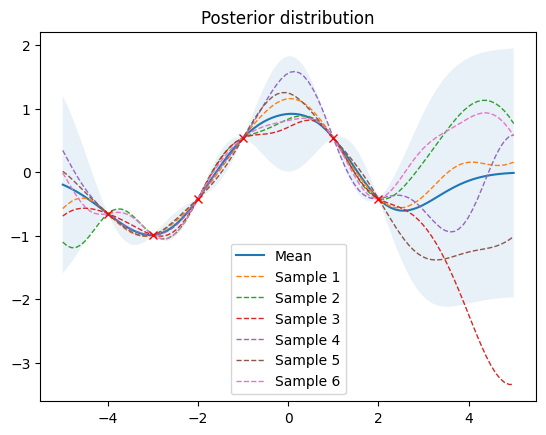

In [3]:
from numpy.linalg import inv
def update_posterior(X_s, X_train, Y_train, l = 1.0, sigma_F = 1.0, sigma_y = 1e-8):
    """
    计算后验分布的均值向量和协方差矩阵
    Args:
        X_s: 新的数据点的input locations
        X_train: 训练数据的input locations
        Y_train: 训练点的值
        l: kernel的参数
        sigma_F: kernel的参数
        sigma_y: 噪声参数
    Returns:
        后验均值向量(n*d)和协方差矩阵(n*n)
    """
    K = ise_kernel(X_train, X_train, l, sigma_F) + sigma_y**2 * np.eye(len(X_train))
    K_s = ise_kernel(X_train, X_s, l, sigma_F)
    K_ss = ise_kernel(X_s, X_s, l, sigma_F) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    # 计算均值向量
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    # 计算协方差矩阵
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    return mu_s, cov_s

X_train = np.array([-4, -3, -2, -1, 1, 2]).reshape(-1,1)
Y_train = np.cos(X_train)
mu_s, cov_s = update_posterior(X_test, X_train, Y_train)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 6)
plot_gp(mu_s, cov_s, "Posterior distribution", X_test, X_train=X_train, Y_train=Y_train, samples=samples)

# 其他（基础知识）

(100, 100)


Text(0.5, 1.0, 'Drawing five random samples from a GP prior')

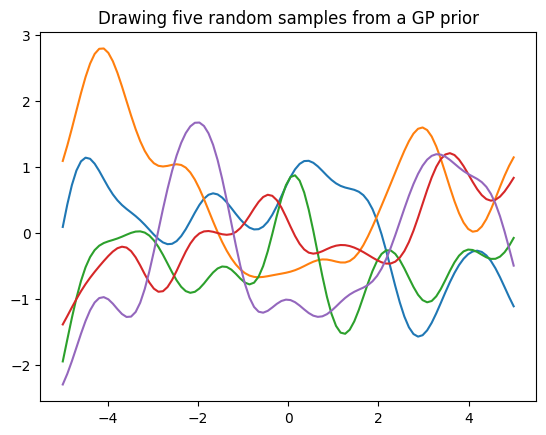

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# 设置随机种子以确保重复性
np.random.seed(8)
def kernel(a, b):
    """定义一个核函数，返回两个输入位置之间的平方指数距离
    将平方运算分解为三个部分
    每个输入位置是多维的，因此需要对所有维度求和
    """
    sq_dist = np.sum(a**2,1).reshape(-1,1) +np.sum(b**2,1) - 2*np.dot(a,b.T)
    return np.exp(-sq_dist)

# 设置当函数增长到无穷大时函数的输入位置数量 setting number of input locations which approximates a function when growing to infinity
n = 100
X_test = np.linspace(-5,5,n).reshape(-1,1) 
# 计算pairwise distance, 得到一个nxn 矩阵
K = kernel(X_test, X_test)
print(K.shape)

# 沿对角线元素添加一个小的数以确保cholesky分解有效
L = np.linalg.cholesky(K + 1e-10*np.eye(n))
# calculating functional samples by multiplying the sd with standard normal samples
samples = np.dot(L,np.random.normal(size=(n,5)))
plt.plot(X_test, samples)
plt.title("Drawing five random samples from a GP prior")